In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
import pandas as pd
import pylab as plt
import pystan
import seaborn as sns
import numpy as np
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

![](./assets/DJlogo_alpha.png?raw=true)<!-- .element height="80%" width="80%" -->

<http://www.DataJavelin.com>
## Dr Peter Hurley & Dr Phil Rooney

# Bayesian Data Analysis Workflow with Stan

A good workflow for developing and testing models is essential!

1. Model Building
2. Model Inference
3. Model Checking
4. Model Improvment

For more detailed information see [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) book by Andrew Gelman and co-authors and [Michael Betancourt's case study](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#1_bayesian_modeling_and_inference)

Lets go through steps with an example problem

## Golf putting
An example from [Andrew Gelman's blog](https://statmodeling.stat.columbia.edu/2019/03/21/new-golf-putting-data-and-a-new-golf-putting-model/)

In [2]:
data=pd.read_csv('orig_golf_data.txt',sep='\s+')
data[0:5]

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


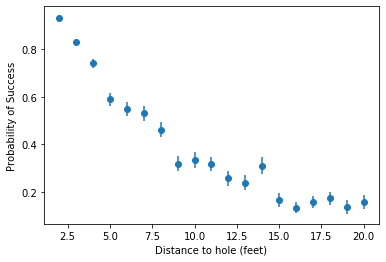

In [3]:
p=data['y']/data['n']
error=np.sqrt(p*(1-p)/data['n'])
plt.errorbar(data['x'],data['y']/data['n'],yerr=error,fmt='o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

With error bars taken as simple classical standard deviations $\sqrt{\hat{p}_j(1-\hat{p}_j)/n_j}$ where $\hat{p}_j=y_j/n_j$ success rate for putts taken at distance $x_j$.

## Model Building


### Build generative model
1. construct a probabilistic generative model of the observation process. 
2. generative observation model can be a crude approximation to the complexity of the true measurement process


An ideal generative model will use mathematical functions to describe how an observation is produced based on a given model configuration. It is described as generative as it models how the data was generated (i.e. joint distribution)

Simple approximations are often good enough to answer even sophisticated questions. We describe the model as generative as we are trying to build a model that replicates how the data was generated. 

Often it is helpful to visualise the model via a probabilistic graphical model. These visualisations are a good way of understanding and showing how different variables relate and depend on each other.

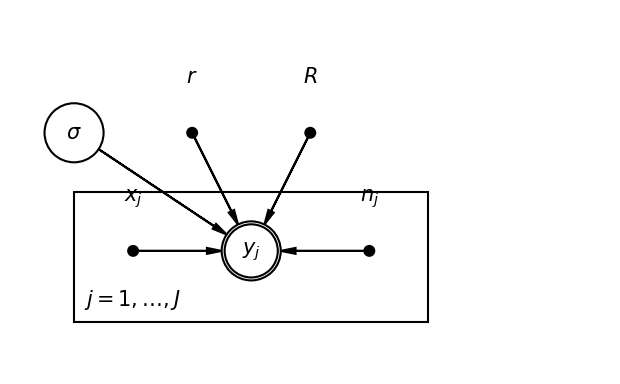

In [4]:
import daft
pgm = daft.PGM(shape=(5,3),observed_style="inner",dpi=150)

# Hierarchical parameters.
pgm.add_node("sigma", r"$\sigma$", 0.5, 2)
pgm.add_node("r", r"$r$", 1.5, 2,fixed=True)
pgm.add_node("R", r"$R$", 2.5, 2,fixed=True)


# Latent variable.
pgm.add_node("x", r"$x_j$", 1, 1,fixed=True)

# Data.
pgm.add_node("y", r"$y_j$", 2, 1, observed=True)
pgm.add_node("n", r"$n_j$", 3, 1,fixed=True)

pgm.add_edge('sigma','y')
pgm.add_edge('r','y')
pgm.add_edge('R','y')
pgm.add_edge('x','y')
pgm.add_edge('n','y')

pgm.add_plate([0.5, 0.5, 3, 1], label=r"$j = 1, \ldots, J$", shift=-0.1)

# Render and save.
pgm.render()
pgm.show()

#### Our second model, from first principles 
We want to model the probability of success in golf putting as a function of distance from the hole? What is it about the distance that makes it harder to make a putt?


![alt text](./assets/golfpicture-1024x249.png "Logo Title Text 1")


$$\mbox{Pr}\left(|\mbox{angle}| < \sin^{-1}((R-r)/x)\right) = 2\Phi\left(\frac{\sin^{-1}((R-r)/x)}{\sigma}\right) - 1$$

$\Phi$ is the cumulative normal distribution. Multiply by 2 since angle can be $+$ or $-$, subtract 0.5 twice as we are looking at $\mbox{Pr}\left(0<angle<\sin^{-1}((R-r)/x)\right)$ times 2



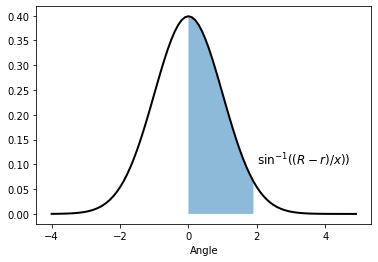

In [10]:
from scipy.stats import norm
rv = norm()
x=np.arange(-4,5,0.1)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
plt.fill_between(np.arange(0,2,0.1),rv.pdf(np.arange(0,2,0.1)),alpha=0.5)
plt.xlabel('Angle')
plt.text(2, 0.1, r'$\sin^{-1}((R-r)/x))$', fontsize=12);


In [11]:
r=(1.68/2)/12
R=(4.25/2)/12
def success_curve(sigma,x):
    return 2*rv.cdf(np.arcsin(((R-r)/x))/sigma)-1

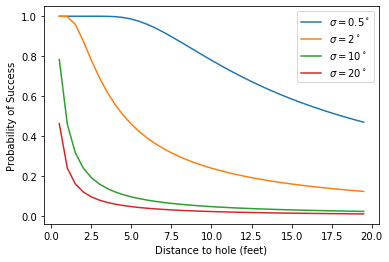

In [12]:
x=np.arange(0.0,20,0.5)
for sigma_angle in [0.5,2,10,20]:
    sigma=sigma_angle*np.pi/180.0
    plt.plot(x,success_curve(sigma,x),label=r'$\sigma={}^\circ$'.format(sigma_angle))
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );
plt.legend()


Always good to think about problem and put informative priors if possible.

Thinking about our model,
Priors:
* $\sigma$ can't be lower than 0 or higher than $\pi/2$

### Writing the model in Stan
* A Stan program is organized into a sequence of named blocks


In [8]:
example_model="""functions {
// ... function declarations and definitions ...
}
data {
// ... declarations ...
}
transformed data {
// ... declarations ... statements ...
}
parameters {
// ... declarations ...
} 
transformed parameters {
// ... declarations ... statements ...}
model {
// ... declarations ... statements ...
}
generated quantities {
// ... declarations ... statements ...
}
"""

### Other things to note:
* Add comments with `\\`
* Sampling statements with `~`
* Can print output with `print()`
* `;` at end of each line


Documentation for Stan: https://mc-stan.org/docs/2_19/stan-users-guide/index.html


In [44]:
golf_model_2="""
data {
  int J;
  int n[J];
  vector[J] x;
  int y[J];
  real r;
  real R;
  int fit;//boolean for fitting
}
transformed data {
  vector[J] threshold_angle = asin((R-r) ./ x);
}
parameters {
  real<lower=0,upper=0.5*pi()> sigma;
}

model {
  vector[J] p = 2*Phi(threshold_angle / sigma) - 1;
    if (fit>0){
  y ~ binomial(n, p);
  }
}
generated quantities {
  real sigma_degrees = sigma * 180 / pi();
  real R_new;
  int y_pred[J];
  R_new=10.0*sin(inv_Phi(1.5/2)*sigma)+r;

  
  for (i in 1:J){
    y_pred[i]=binomial_rng(n[i],2*Phi(threshold_angle[i] / sigma) - 1);
}
}
"""

In [45]:
sm=pystan.StanModel(model_code=golf_model_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e4a11569efbbcf720c0f46dc3faab0e5 NOW.


### Analyse the Generative Ensemble
* Analyse a range of samples from generative model
* Check outputs are realistic
* Good way of checking model (especially priors) is behaving appropriately and how you expect

Before drawing inferences from a real observation, we first want to analyse a range of samples from our generative model to check that the resulting putting success relation is realistic. This is a good way of checking that the prior distribution is sensible and the model is behaving approriately.

To do that we first simulate parameters and observations from the complete generative model. We do this with the Python interface to Stan, PyStan.

Simulating from the generative model allows us to see how our model and the prior choices we have made, affect the trend and whether they are realistic or whether we need to go back and rethink the priors. Simulating from the generative model also gives us simulated data for which we know the true parameter values. We can then use this simulated data to carry out the same inference procedures we would run on real data to test whether we can accurately recover the true parameter values. This gives us confidence that when we run it on real data we can trust the parameter values we get.

In [13]:
model_data={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':data['y'],
        'r':r,
        'R':R,
        'fit':0}


In [14]:
fit=sm.sampling(data=model_data,chains=4,iter=1000,seed=194838)

In [15]:
fit

Inference for Stan model: anon_model_677a969d4f02b412b1761dee60977fa8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           0.78    0.02   0.45   0.05   0.39   0.78   1.18   1.53    895    1.0
sigma_degrees  44.69    0.86  25.82   2.84  22.38  44.65  67.51  87.53    895    1.0
y_pred[1]     165.94    7.76 235.89   37.0   53.0   81.0  157.0 1046.3    923    1.0
y_pred[2]       56.6    3.15   93.6    9.0   17.0   26.0   52.0 369.95    883    1.0
y_pred[3]      29.14    1.82  53.72    3.0    8.0   13.0   26.0 186.17    869    1.0
y_pred[4]      18.53    1.26  36.91    2.0    5.0    8.0   16.0  119.6    862    1.0
y_pred[5]       12.2     0.9  25.95    1.0    3.0    5.0  10.55   75.6    839    1.0
y_pred[6]      10.07    0.78  22.63    0.0    2.0    4.0    9.0  61.38    833    1.0
y_pred[7]       8.38    0.68   19.7    0.0    2.

* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* The amount by which autocorrelation within the chains increases uncertainty in estimates can be measured by effective sample size, $n_{eff}$. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since Stan is efficient, no need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

In [16]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.15) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.01) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.05) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.41) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

*Divergent transitions*:Critical warning. Step size is too large. Try fixing by increasing `adapt_delta` e.g. `fit=sm.sampling(data=data,control=dict(adapt_delta=0.9)`

*Maximum Tree depth*: Not as critical. A detail specific to NUTS algorithm. Fix by increasing tree depth e.g. `fit=sm.sampling(data=data,control=dict(max_treedepth=15)`

*BFMI low*: Bayesian Fraction of Missing Information. Adaptation phase of the Markov Chains did not turn out well and those chains likely did not explore the posterior distribution efficiently. Can try running for more iterations, but probably need to re-parameterise model.


Details on diagnostics are [here](https://mc-stan.org/misc/warnings.html). Good explanation for divergences can also be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762)

Prior distribution on parameters:

Text(0.5, 0, '$\\sigma (^\\circ)$')

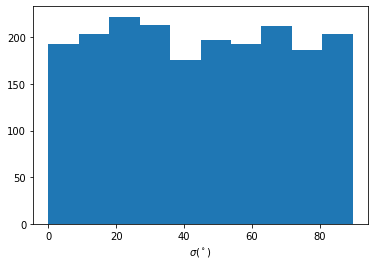

In [17]:
plt.hist(fit['sigma_degrees'])
plt.xlabel(r'$\sigma (^\circ)$')


Lets look at Prior predicitive distribution

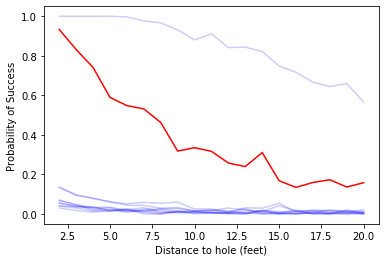

In [19]:

for i in range(0,1000,100):
    plt.plot(data['x'],fit['y_pred'][i,:]/data['n'],'b',alpha=0.2)
plt.plot(data['x'],data['y']/data['n'],'r',label='data')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );


### Fit the Simulated Observations and Evaluate
* Test ability to fit model (testing fitting algorithms)
* Fit samples from the prior predicitive distribution
* Compare Posterior probabillity distribution with truth


We have generated a sample of simulated observations from our generative model. To test our ability to draw inferences with the model when using real data, we can attempt to fit each of these simulated observations and construct a posterior distribution on the parameters of interest. The advantage of fitting simulated results is we know the truth and so we can compare the posterior probability distributions coming from the inference with the true values. Lets start with fitting one sample from our simulated observations.

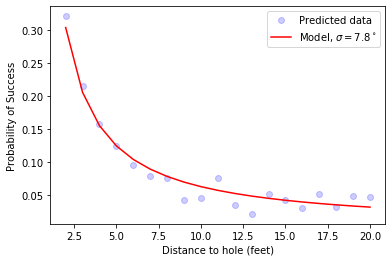

In [22]:
s=8
plt.plot(data['x'],fit['y_pred'][s,:]/data['n'],'bo',alpha=0.2,label='Predicted data')
plt.plot(data['x'],success_curve(fit['sigma'][s],data['x']),'r',label='Model, $\sigma={:3.1f}^\circ$'.format(fit['sigma_degrees'][s]))
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

plt.legend();

In [23]:
data_samp={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':fit['y_pred'][s,:].astype('int'),
        'r':r,
        'R':R,
        'fit':1}


In [24]:
fit_samp=sm.sampling(data=data_samp,chains=4,iter=1000,seed=10)

In [25]:
fit_samp

Inference for Stan model: anon_model_677a969d4f02b412b1761dee60977fa8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           0.13  1.5e-4 4.1e-3   0.13   0.13   0.13   0.14   0.14    781   1.01
sigma_degrees   7.64  8.4e-3   0.24   7.19   7.48   7.64   7.81    8.1    781   1.01
y_pred[1]      449.8    0.62  21.93  409.0  435.0  449.0  465.0  494.0   1252    1.0
y_pred[2]     146.63    0.29  11.73  125.0  138.0  146.0  154.0  170.0   1673    1.0
y_pred[3]      72.61    0.19   8.07   58.0   67.0   72.0   78.0   88.6   1801    1.0
y_pred[4]      44.99    0.15   6.54   33.0   41.0   45.0   49.0   58.0   1873    1.0
y_pred[5]      29.07    0.13   5.16   19.0   25.0   29.0   32.0   40.0   1651    1.0
y_pred[6]      23.39    0.11   4.64   15.0   20.0   23.0   27.0   33.0   1942    1.0
y_pred[7]      19.15     0.1   4.25   11.0   16.

In [26]:
pystan.diagnostics.check_hmc_diagnostics(fit_samp)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

Text(0.5, 0, '$\\sigma (^\\circ)$')

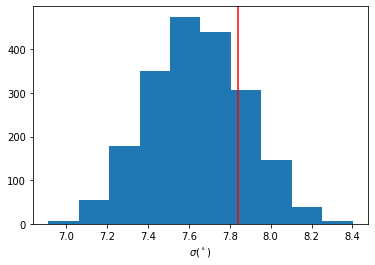

In [27]:
plt.hist(fit_samp['sigma_degrees'])
plt.axvline(fit_samp['sigma_degrees'][s],color='r')
plt.xlabel(r'$\sigma (^\circ)$')



When analysing posterior probability distributions for model parameters, it is good practise to do so alongside the prior distribution. This allows us to visualise whether we are gaining much information from the data, beyond our prior knowledge.

Lets plot replicated data from our model fit, and compare to fitted data

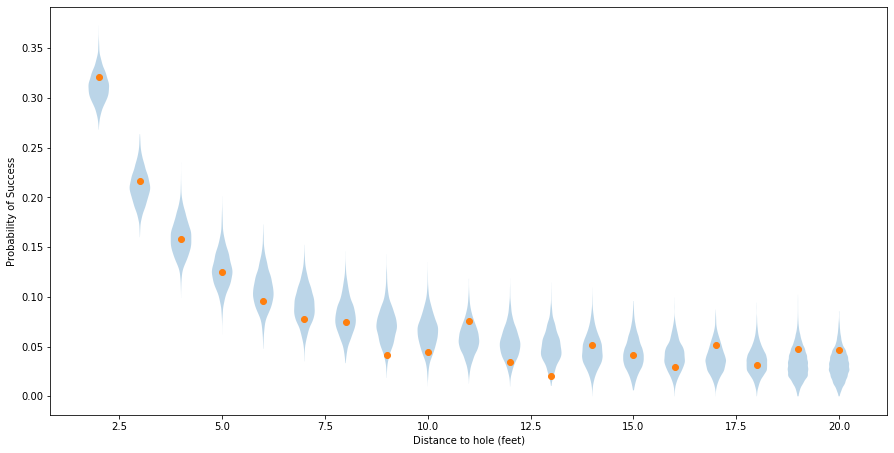

In [28]:
plt.figure(figsize=(15,7.5))
plt.violinplot(fit_samp['y_pred']/data['n'].values,positions=data['x'],showextrema=False);
plt.plot(data['x'],fit['y_pred'][s,:]/data['n'],'o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

### Evaluate Prior-Posterior Consistency

We have fitted one sample. To be confident our chosen fitting algorithm works for all possible values (i.e. within Prior) we should fit *many* samples

 To check the model and our inference technique (i.e. the algorithm used to fit the data) is perfoming appropriately, you can carry out simulated-based calibration. This involved fitting each prior sample as if it were data. The posterior distributions on the fits should look like the prior. This approach checks this is correct. If everything is working, the plots below for each parameter should be uniform.
 
For details, see [Talts et al. 2018](https://arxiv.org/pdf/1804.06788) and [Michael Betancourt's case study](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#22_computational_faithfulness)


In [29]:
samples=[]
n_samp=100
sigma_cal=np.empty(n_samp)
for s in range(0,n_samp):
    #set data to one of the samples
    data_samp={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':fit['y_pred'][s,:].astype('int'),
        'r':r,
        'R':R,
        'fit':1}
    #fit the data
    fit_tmp=sm.sampling(data=data_samp,chains=4,iter=1000,seed=10,verbose=False)
    #append samples to list
    samples.append(pd.DataFrame(fit_tmp['sigma_degrees'],columns=['sigma_degrees']))
    #carry out calibration statistic
    sigma_cal[s]=np.sum(fit_tmp['sigma_degrees']<fit['sigma_degrees'][s])
    
samples=pd.concat(samples)

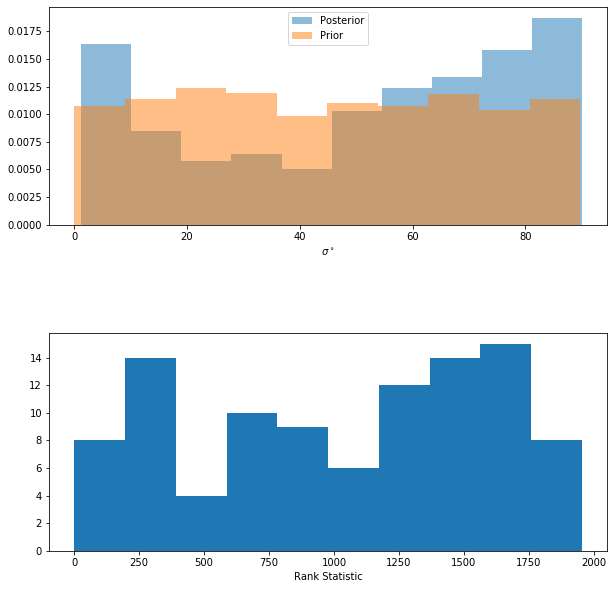

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.hist(samples['sigma_degrees'],density=True,alpha=0.5,label='Posterior');
plt.hist(fit['sigma_degrees'],density=True,alpha=0.5,label='Prior');
plt.xlabel(r'$\sigma ^\circ$');
plt.legend()
plt.subplot(2,1,2)
plt.hist(sigma_cal)
plt.xlabel('Rank Statistic')
plt.subplots_adjust(hspace=0.5)

### Analyse Posterior Behaviours

**Z score**
$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

how accurately the posterior recovers ground truth and whether there is any bias. Close to zero indicate more accurate, less biased posteriors.

**Posterior Shrinkage**
$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Close to zero indicates dominated by prior, close to one indicates dominated by data.

Assuming that we are accurately recovering posteriors across all of the simulated observations then we can proceed to analyse the range of behaviors in these posteriors. For example, the posterior z-score of a given parameter,

$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

quantifies how accurately the posterior recovers the ground truth and whether there is any bias. Values close to zero indicate more accurate, less biased posteriors.

At the same time the posterior shrinkage,

$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Our visualisation of the posterior and prior for $\alpha$ and $\beta$ had already indicated that the inference had given us information on both parameters. Shrinkage allows us to quantify this. A value near zero indicates that the data provide little information beyond that encoded in the prior distribution while shrinkage near one indicates highly informative observations.


<img src="./assets/sensitivity.png" alt="Drawing" style="width: 600px;"/>

In [31]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))
n_post_samps=int(len(samples)/n_samp)

z_score_array=np.empty((1,n_samp))
shrinkage_array=np.empty((1,n_samp))
for i in range(0,n_samp):
    z_score_array[0,i]=zscore(samples['sigma_degrees'][i*n_post_samps:(i+1)*n_post_samps],fit['sigma_degrees'][i])
    shrinkage_array[0,i]=shrinkage(samples['sigma_degrees'][i*n_post_samps:(i+1)*n_post_samps],fit['sigma_degrees'])


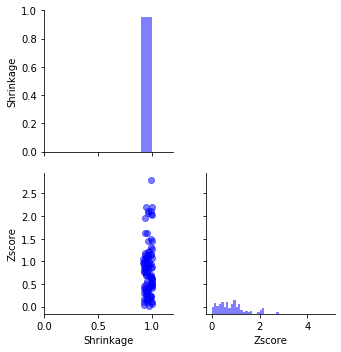

In [32]:
g=sns.PairGrid(pd.DataFrame(np.vstack((shrinkage_array[0,:],z_score_array[0,:])).T,columns=['Shrinkage','Zscore']))
g.map_diag(plt.hist,color='blue',alpha=0.5,bins=np.arange(0,5,0.1))
g.map_lower(plt.scatter,color='blue',alpha=0.5)
g.axes[1,0].set_xlim(0,1.2)
g.axes[0,1].set_axis_off()

## Model Inference
Having satisfied ourselves that model is behaving as we expect, lets fit our model to observational data

In [46]:
model_data={
        'J':len(data),
        'n':data['n'],
        'x':data['x'],
        'y':data['y'],
        'r':r,
        'R':R,
        'fit':1}

In [47]:
fit_obs=sm.sampling(data=model_data,chains=4,iter=1000,seed=194838)

In [48]:
fit_obs

Inference for Stan model: anon_model_e4a11569efbbcf720c0f46dc3faab0e5.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma           0.03  1.3e-5 3.8e-4   0.03   0.03   0.03   0.03   0.03    861   1.01
sigma_degrees   1.53  7.5e-4   0.02   1.49   1.51   1.53   1.54   1.57    861   1.01
R_new           0.25  8.8e-5 2.6e-3   0.24   0.25   0.25   0.25   0.25    861   1.01
y_pred[1]     1379.1    0.22   9.01 1360.0 1373.0 1380.0 1385.0 1396.0   1702    1.0
y_pred[2]     568.73    0.27  11.22  547.0  561.0  569.0  576.0  591.0   1790    1.0
y_pred[3]     311.61    0.27  10.75  290.0  305.0  312.0  319.0  333.0   1627    1.0
y_pred[4]     204.05    0.22   9.26  186.0  198.0  204.0  211.0  222.0   1817    1.0
y_pred[5]     134.96    0.19   8.33  118.0  129.0  135.0  141.0  151.0   1872    1.0
y_pred[6]     111.15    0.18   7.99   95.0  106.

### Diagnostic tests

In [49]:
pystan.diagnostics.check_hmc_diagnostics(fit_obs,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.29) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.3) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1.21) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.28) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

## Model Checking

Text(0.5, 0, '$\\sigma (^\\circ)$')

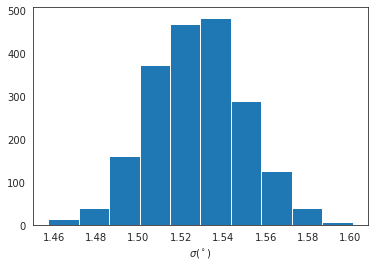

In [50]:
plt.hist(fit_obs['sigma_degrees'])
plt.xlabel(r'$\sigma (^\circ)$')


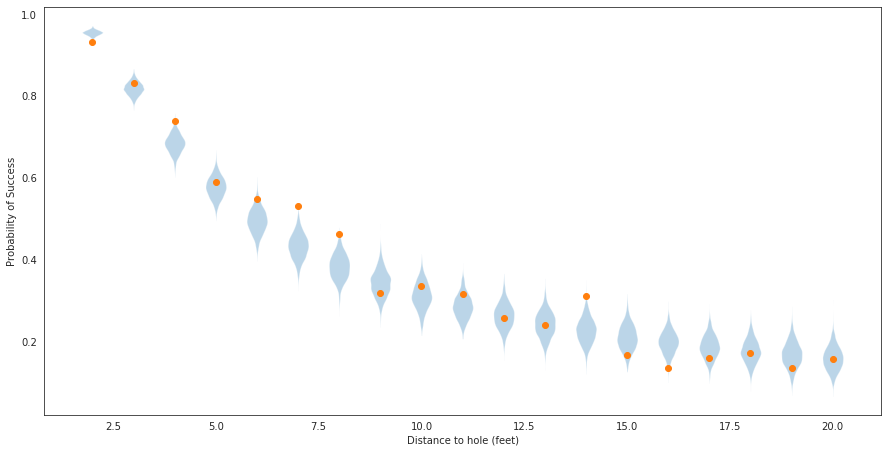

In [51]:
plt.figure(figsize=(15,7.5))
plt.violinplot(fit_obs['y_pred']/data['n'].values,positions=data['x'],showextrema=False);
plt.plot(data['x'],data['y']/data['n'],'o')
plt.xlabel('Distance to hole (feet)');
plt.ylabel('Probability of Success' );

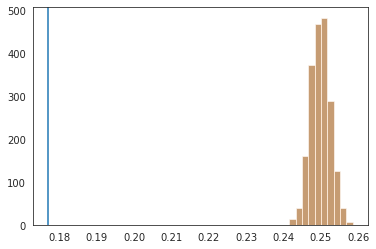

In [55]:
plt.hist(fit_obs['R_new'],alpha=0.5);
plt.hist(R_new,alpha=0.5);
plt.axvline(x=R)

### Posterior Predicitive Checks

In [54]:
import scipy.stats as st

R_new=10.0*np.sin(st.norm.ppf(1.5/2)*fit_obs['sigma'])+r

When examining goodness of fits, the typical method is to look at the residuals. i.e. $\frac{data - model}{\sigma}$. Because we have distribution of $y^{rep}$, we can do this in a more probabilisitic way using posterior predictive checks. For more information on posterior predictive checks, [Gelman et al. 1996](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf) is a good starting point.

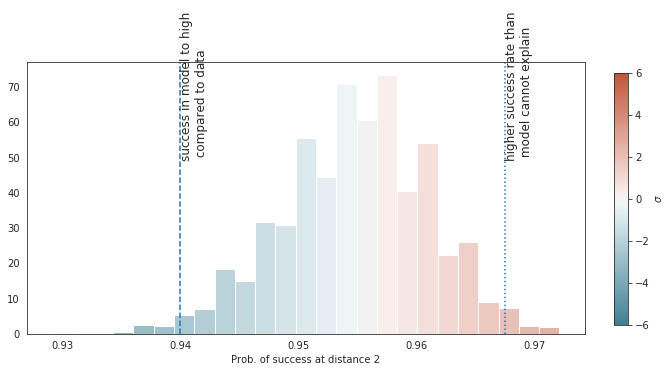

In [39]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(fit_obs['y_pred'][:,0]/data['n'].values[0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(fit_obs['y_pred'][:,0]/data['n'].values[0]))/np.std(fit_obs['y_pred'][:,0]/data['n'].values[0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('Prob. of success at distance '+str(data['x'].values[0]))
plt.axvline(0.94, linestyle='--')
plt.axvline(0.9675,linestyle=':')
plt.annotate('higher success rate than \n model cannot explain',xy=(0.9675, 20),  xycoords='data',
            xytext=(0.9675, 50), textcoords='data',rotation='vertical',size='large')
plt.annotate('success in model to high\n compared to data',xy=(0.94, 20),  xycoords='data',
            xytext=(0.94, 50), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.94, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

We can calculate fraction of $y^{rep}$ samples above and below real success value. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real success measurement, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* $\sim 0.5$ (i.e. near the middle of the distribution) means our model is consistent with the data 
* $0.99$ or $0.01$ (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that  $\sigma < -3$ or $\sigma > 3$ indicates a problem with the model.

For more information on posterior predictive checks, see:
* [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)
* [http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf](http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf)

In [40]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval
pvalues=Bayes_P_value(fit_obs['y_pred']/data['n'].values,data['y']/data['n'])

In [41]:
pvalues

array([-3.29052673,  0.6998836 ,  2.38670773,  0.35045134,  1.60724789,
        3.29052673,  2.54269882, -0.83983662,  0.60677536,  0.9862713 ,
       -0.2301181 , -0.15096922,  2.54269882, -1.49085336, -2.38670773,
       -1.08031934, -0.21341921, -1.16752108, -0.13703896])

## Model Improvement
What is wrong with our model?

How could we improve it? Add a component for distance?

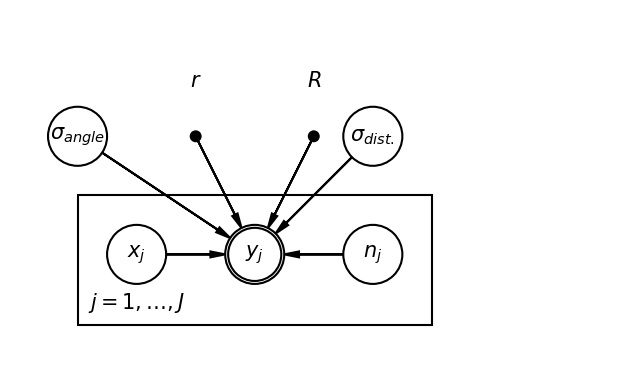

In [15]:
pgm = daft.PGM(shape=(5,3),observed_style="inner",dpi=150)

# Hierarchical parameters.
pgm.add_node("sigma_angle", r"$\sigma_{angle}$", 0.5, 2)
pgm.add_node("r", r"$r$", 1.5, 2,fixed=True)
pgm.add_node("R", r"$R$", 2.5, 2,fixed=True)
pgm.add_node("sigma_dist", r"$\sigma_{dist.}$", 3, 2)



# Latent variable.
pgm.add_node("x", r"$x_j$", 1, 1)

# Data.
pgm.add_node("y", r"$y_j$", 2, 1, observed=True)
pgm.add_node("n", r"$n_j$", 3, 1)

pgm.add_edge('sigma_angle','y')
pgm.add_edge('sigma_dist','y')

pgm.add_edge('r','y')
pgm.add_edge('R','y')
pgm.add_edge('x','y')
pgm.add_edge('n','y')

pgm.add_plate([0.5, 0.5, 3, 1], label=r"$j = 1, \ldots, J$", shift=-0.1)

# Render and save.
pgm.render()
pgm.show()

### Hierarchical model for individuals
If we had success rates for individual golfers, we could extend the model even further.
* First, we would have a $\sigma_{angle}$ and $\sigma_{dist.}$ for each golfer.
* Secondly we could constrain the individual $\sigma_{angle}$ and $\sigma_{dist.}$ to come from an overall distribution, e.g. normal distribution, with $\mu$ and $\sigma$. Constraining hierarchicaly, allows us to pool and share information across golfers, yet also get a handle on values for the individual.

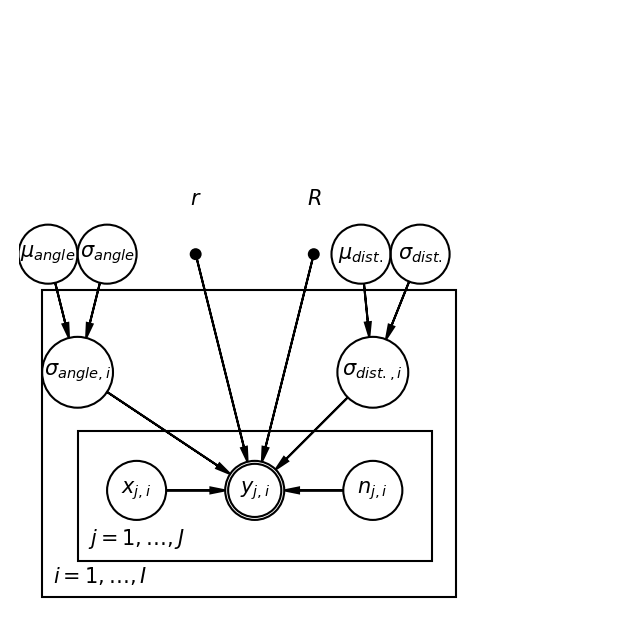

In [28]:
pgm = daft.PGM(shape=(5,5),observed_style="inner",dpi=150)

# Hierarchical parameters.
pgm.add_node("sigma_angle", r"$\sigma_{angle,i}$", 0.5, 2,scale=1.2)
pgm.add_node("mu_a", r"$\mu_{angle}$", 0.25, 3)
pgm.add_node("sig_a", r"$\sigma_{angle}$", 0.75, 3)
pgm.add_node("r", r"$r$", 1.5, 3,fixed=True)
pgm.add_node("R", r"$R$", 2.5, 3,fixed=True)
pgm.add_node("sigma_dist", r"$\sigma_{dist.,i}$", 3, 2,scale=1.2)
pgm.add_node("mu_d", r"$\mu_{dist.}$", 2.90, 3)
pgm.add_node("sig_d", r"$\sigma_{dist.}$", 3.40, 3)



# Latent variable.
pgm.add_node("x", r"$x_{j,i}$", 1, 1)

# Data.
pgm.add_node("y", r"$y_{j,i}$", 2, 1, observed=True)
pgm.add_node("n", r"$n_{j,i}$", 3, 1)

pgm.add_edge('sigma_angle','y')
pgm.add_edge('sigma_dist','y')
pgm.add_edge('mu_a','sigma_angle')
pgm.add_edge('sig_a','sigma_angle')
pgm.add_edge('mu_d','sigma_dist')
pgm.add_edge('sig_d','sigma_dist')


pgm.add_edge('r','y')
pgm.add_edge('R','y')
pgm.add_edge('x','y')
pgm.add_edge('n','y')

pgm.add_plate([0.5, 0.5, 3, 1], label=r"$j = 1, \ldots, J$", shift=-0.1)
pgm.add_plate([0.2, 0.2, 3.5, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)


# Render and save.
pgm.render()
pgm.show()